The purpose of this file is to explore sampling methods for our rare class classification target of ArrDelayMinutes. The result should be that we are able to have the samples more equal than what exists currently.

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

combinedFlights2018csv = "../archive\Combined_Flights_2018.csv"
combinedFlights2018parq = "../archive/Combined_Flights_2018.parquet"
combinedFlights2019parq = "../archive/Combined_Flights_2019.parquet"

In [3]:
data18 = pd.read_parquet(combinedFlights2018parq)

In [4]:
data19 = pd.read_parquet(combinedFlights2019parq)

In [5]:
df18 = data18
print(data18.shape)

(5689512, 61)


In [6]:
df19 = data19
print(data19.shape)

(8091684, 61)


In [7]:
def PrintInvalidEntriesForArrDelayMinutes(dataFrame):
    totalEntries = dataFrame.ArrDelayMinutes.shape[0]
    numInvalidEntries = dataFrame.ArrDelayMinutes.isnull().sum()
    print(f"There are {totalEntries:,} total entries for ArrDelayMinutes")
    print(f"Of those, there are {numInvalidEntries:,} NaN entries for ArrDelayMinutes")

def RemoveRowsWithInvalidDataForArrDelayMinutes(dataFrame):
    print("Before cleaning:")
    PrintInvalidEntriesForArrDelayMinutes(dataFrame)
    cleanedDataFrame = dataFrame.dropna(subset=['ArrDelayMinutes'])
    print()

    print("After cleaning:")
    PrintInvalidEntriesForArrDelayMinutes(cleanedDataFrame)
    return cleanedDataFrame
    
def ShowHistArrDelayMinutes(dataFrame):
    histogram = dataFrame['ArrDelayMinutes'].plot(kind="hist", bins=50, xlabel="test")
    histogram.set_title("ArrDelayMinutes Distribution")
    histogram.set_xlabel("Minutes of Delay")
    histogram.set_ylabel("Number of Occurances")

Do some data cleanup

In [8]:
# Remove rows with invalid data
df18 = RemoveRowsWithInvalidDataForArrDelayMinutes(df18)
df19 = RemoveRowsWithInvalidDataForArrDelayMinutes(df19)

Before cleaning:
There are 5,689,512 total entries for ArrDelayMinutes
Of those, there are 102,893 NaN entries for ArrDelayMinutes

After cleaning:
There are 5,586,619 total entries for ArrDelayMinutes
Of those, there are 0 NaN entries for ArrDelayMinutes
Before cleaning:
There are 8,091,684 total entries for ArrDelayMinutes
Of those, there are 174,420 NaN entries for ArrDelayMinutes

After cleaning:
There are 7,917,264 total entries for ArrDelayMinutes
Of those, there are 0 NaN entries for ArrDelayMinutes


Combine 2018 and 2019 data

In [9]:
dfCombined = pd.concat([df18, df19], axis=0)
print(dfCombined.shape)


(13503883, 61)


Show the distribution

Combined Histogram


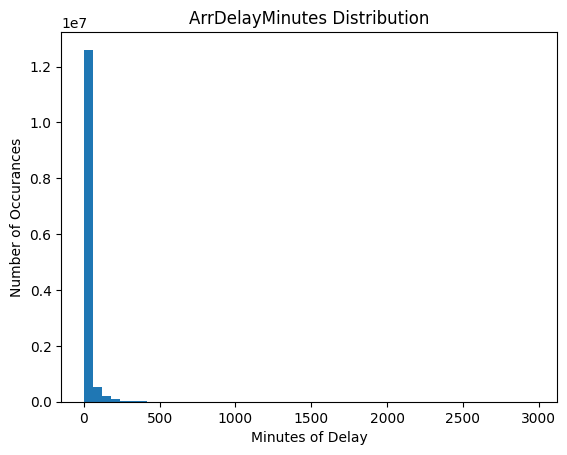

In [10]:
print("Combined Histogram")
ShowHistArrDelayMinutes(dfCombined)

Judging from our previous binning attempts without samples of 0, the bins were in sizes on average of 950,500. We'll remove the number of samples of value 0 to this size.

In [12]:
def GetDataFrameUndersampleValuesOfZero(df):
    occurancesToKeep = 950500

    # split into zero and non-zero helps
    # make the calculation go faster
    dfOnlyZero = df[df['ArrDelayMinutes']==0]
    dfNotZero = df[df['ArrDelayMinutes']!=0]
    numSamplesValueZero = len(dfOnlyZero)
    numSamplesValueNotZero = len(dfNotZero)

    print(f'Original shape: {df.shape}')
    print(f'The number of samples of value 0 is: {numSamplesValueZero}')
    print(f'The number of samples not 0 is: {numSamplesValueNotZero}')

    # we're concatonating only the number of samples
    # that we want to keep
    dfUnderSampledToKeep = dfOnlyZero.sample(n=occurancesToKeep)
    print(f'The number of zero value samples kept is: {len(dfUnderSampledToKeep)}')
    dfProcessed = pd.concat([dfNotZero, dfUnderSampledToKeep], axis=0)
    print(f'Shape of the processed dataframe is: {dfProcessed.shape}')

    return dfProcessed    

dfUndersampled = GetDataFrameUndersampleValuesOfZero(dfCombined)


Original shape: (13503883, 61)
The number of samples of value 0 is: 8756324
The number of samples not 0 is: 4747559
The number of zero value samples kept is: 950500
Shape of the processed dataframe is: (5698059, 61)


There are over 8 million entries of early or on-time flights. That's about 65% of our data. We'll recduce the number of samples of this type down to around 1 million to be equal with our other bins.

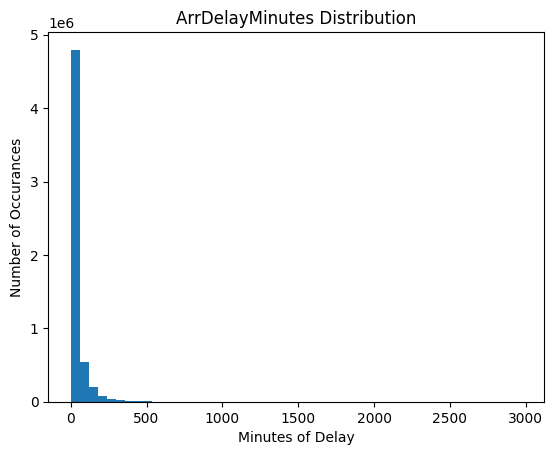

In [13]:
# View the distribution again after undersampling
ShowHistArrDelayMinutes(dfUndersampled)

In [17]:
binArrDelayMinutes = pd.qcut(dfUndersampled.ArrDelayMinutes, q=5, labels=[0,1,2,3,4])
binArrDelayMinutes.value_counts()

1    1231539
0    1183167
4    1130155
3    1091468
2    1061730
Name: ArrDelayMinutes, dtype: int64

In [18]:
# Add bin values back to DataFrame
dfUndersampled['BinArrDelayMinutes'] = binArrDelayMinutes
print(dfUndersampled.shape)
print(dfUndersampled['BinArrDelayMinutes'].value_counts())

(5698059, 62)
1    1231539
0    1183167
4    1130155
3    1091468
2    1061730
Name: BinArrDelayMinutes, dtype: int64


In [19]:
# Send result to parquet
dfUndersampled.to_parquet("Binned_Combined_Flights_2018-2019")